# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [17]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [18]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [19]:
print(env.observation_space)
print(env.action_space)


Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [20]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(14, 10, False)
End game! Reward:  1.0
You won :)

(16, 3, False)
End game! Reward:  1.0
You won :)

(21, 3, True)
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [21]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [22]:
for i in range(2):
    states, actions, rewards = zip(*generate_episode_from_limit_stochastic(env))
    print(states)
    print(actions)
    print(rewards)

((15, 1, False),)
(0,)
(-1.0,)
((15, 9, True),)
(0,)
(-1.0,)


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [23]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    print(generate_episode)
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        for i, state in enumerate(states):
            N[state][actions[i]] += 1.0
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(i+1)]) 
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
        
    return Q

In [24]:
 mc_prediction_q(env, 1, generate_episode_from_limit_stochastic)

<function generate_episode_from_limit_stochastic at 0x00000224AABDC798>


defaultdict(<function __main__.mc_prediction_q.<locals>.<lambda>()>,
            {(20, 10, False): array([0., 0.])})

In [25]:
# N = defaultdict(lambda: np.zeros(env.action_space.n))
# N[1][0] = 5
# N[1][1] = 6
# N[0][0] = 7
# N[0][1] = 8

# for key1 in N.keys():
#     print(N[key1])
# #     for key2 in N[key1][0].keys():
# #         print((key1, key2))
discounts = [1, 0.5, 0.25, 0.125]
print(discounts[:-1])

[1, 0.5, 0.25]


Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

<function generate_episode_from_limit_stochastic at 0x00000224AABDC798>
Episode 500000/500000.defaultdict(<function mc_prediction_q.<locals>.<lambda> at 0x00000224AA7E04C8>, {(21, 10, True): array([ 0.88815883, -0.14799768]), (18, 4, False): array([ 0.18662352, -0.66564673]), (20, 9, False): array([ 0.7552642 , -0.85918854]), (15, 5, True): array([-0.22916667, -0.13163972]), (17, 5, True): array([ 0.05673759, -0.29051383]), (14, 5, False): array([-0.14084507, -0.54198895]), (18, 5, False): array([ 0.25219298, -0.67269737]), (20, 3, False): array([ 0.65329681, -0.88334674]), (12, 10, False): array([-0.57497116, -0.56070656]), (17, 10, False): array([-0.4543662 , -0.70213793]), (13, 6, False): array([-0.16898148, -0.45478036]), (20, 2, False): array([ 0.6314733 , -0.87736626]), (8, 6, False): array([-0.18287938, -0.3255102 ]), (18, 6, False): array([ 0.26384365, -0.66986039]), (15, 10, False): array([-0.58704678, -0.63732346]), (8, 2, False): array([-0.32793522, -0.40936864]), (18, 2, Fa

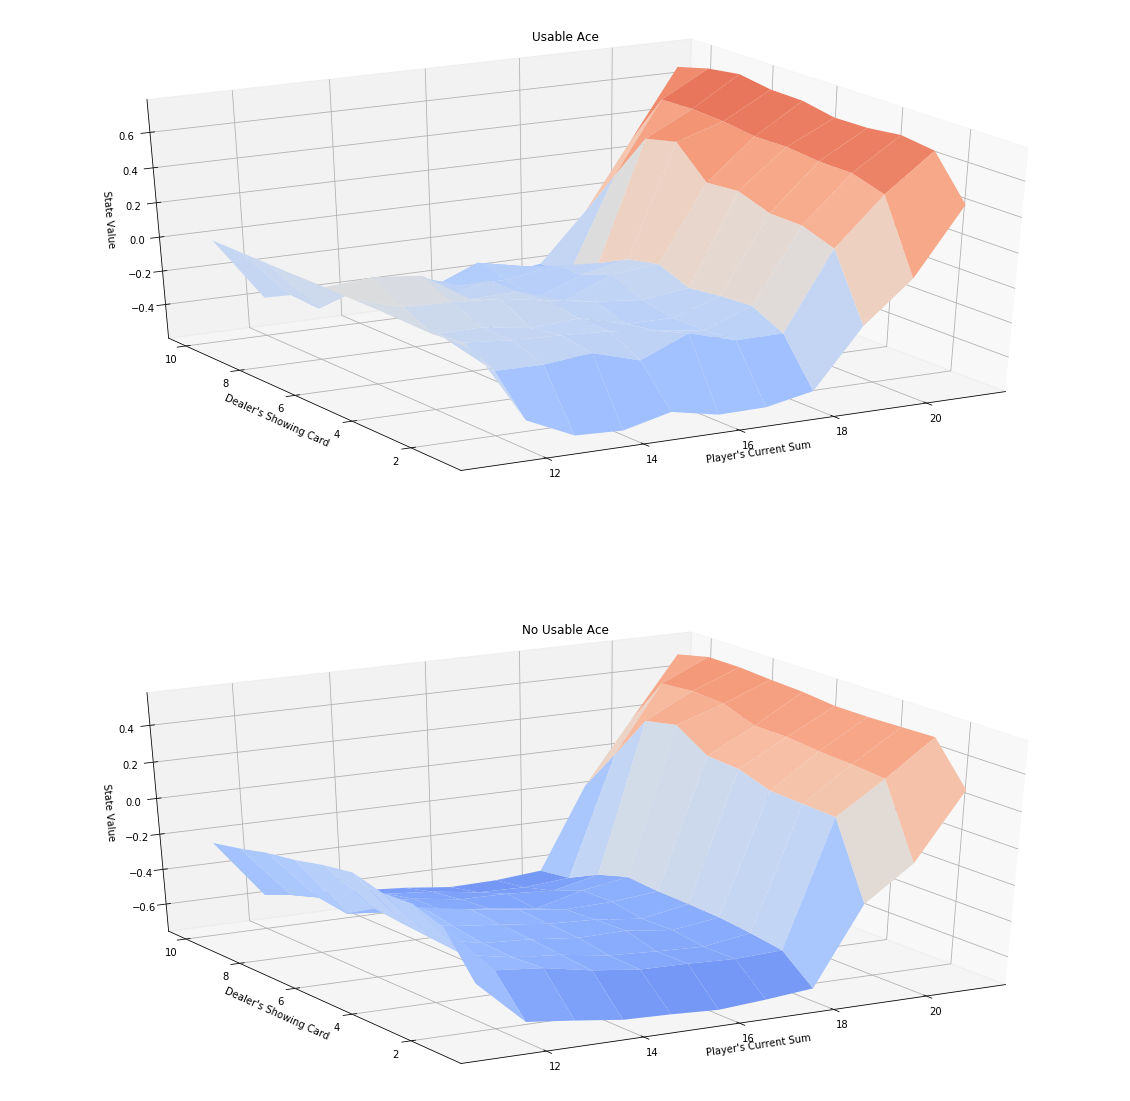

In [26]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [14]:
import random
import numpy as np 

In [80]:
def calc_epsilon(episode_num):
    epsilon = 1.0/episode_num
    if epsilon < 0.05:
        epsilon = 0.05
    return epsilon

def create_policy(Q, epsilon):
    pi = {}
    for key in Q:
        values = Q[key]
#         arr = []
#         first = True
#         for value in values:
#             if value == np.amax(values) and first:
#                 arr.append(1-epsilon)
#                 first = False
#             else:
#                 arr.append(epsilon)
        pi[key] = np.ones_like(values) * epsilon
        max_index = np.argmax(values)
        pi[key][max_index] = 1 - epsilon
    return pi
        
def generate_spisode(env, policy):
    episode = []
    state = env.reset()
    while True:
        if policy.get(state) is not None:
            probs = policy[state]
        else:
            probs = [0.5, 0.5]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done: 
            break
    return episode

In [81]:
def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        e = calc_epsilon(i_episode)
        policy = create_policy(Q, e)
        states, actions, rewards = zip(*generate_spisode(env, policy))
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        for i, state in enumerate(states):
            Q[state][actions[i]] = Q[state][actions[i]] + alpha * (sum(rewards[i:]*discounts[:-(i+1)]) - Q[state][actions[i]])
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [84]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env,500000, 0.02)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

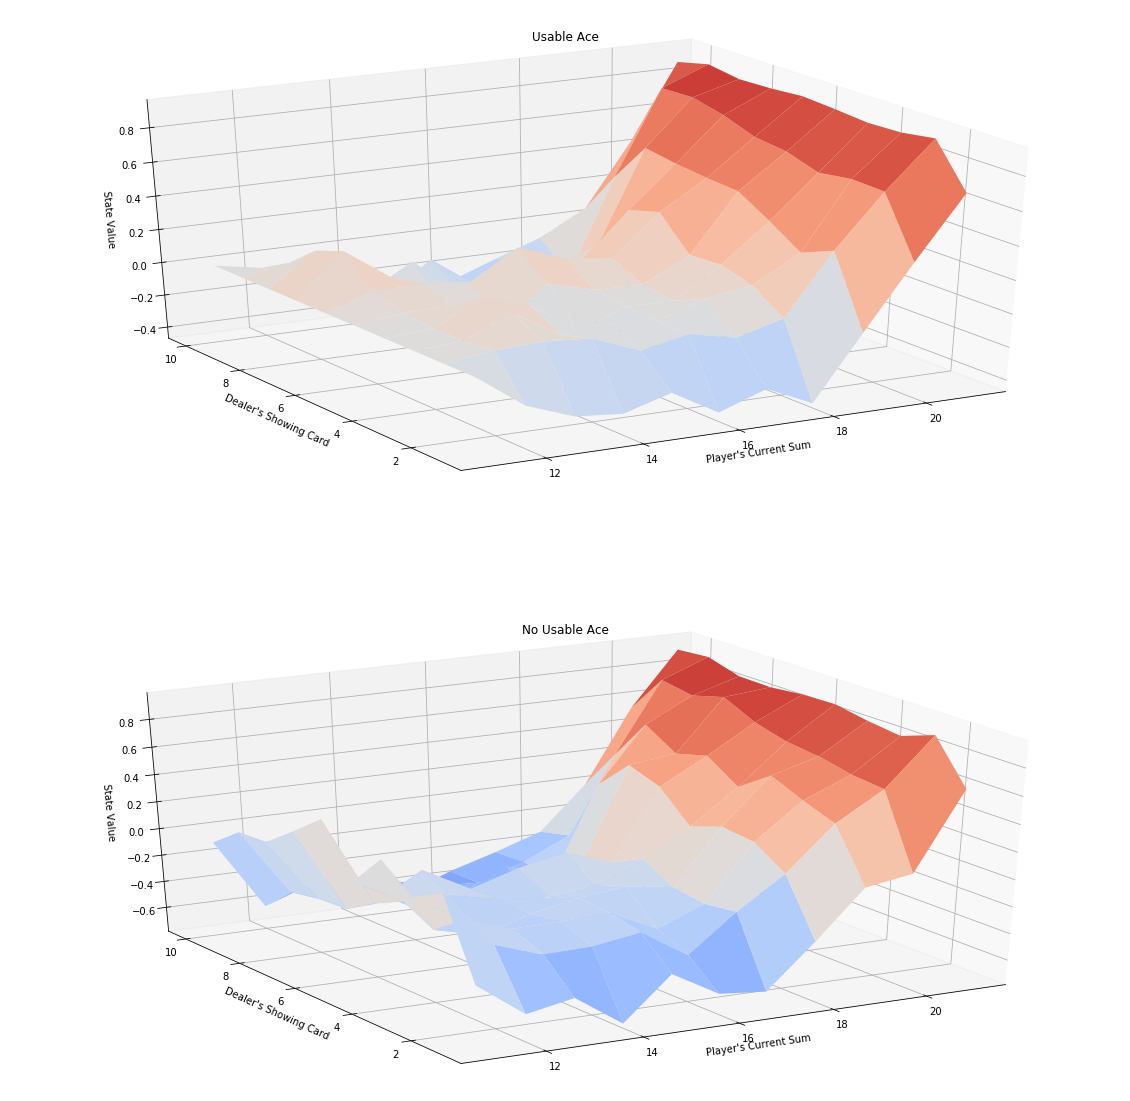

In [85]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [87]:
policy_new = {}
for key in policy:
    values = policy[key]
    policy_new[key] = np.argmax(values)

print(policy_new)

{(13, 8, False): 1, (21, 8, False): 0, (15, 4, False): 0, (20, 5, True): 0, (19, 3, True): 0, (21, 3, True): 0, (17, 8, True): 1, (17, 5, False): 0, (11, 3, False): 1, (21, 3, False): 0, (17, 9, False): 1, (18, 7, False): 0, (12, 10, False): 1, (18, 10, False): 0, (19, 10, False): 0, (16, 1, False): 1, (6, 8, False): 1, (20, 9, False): 0, (21, 9, True): 0, (13, 10, True): 1, (9, 1, False): 1, (21, 4, True): 0, (20, 4, False): 0, (21, 4, False): 0, (13, 1, False): 1, (15, 5, False): 0, (21, 6, True): 0, (19, 8, False): 0, (13, 2, False): 1, (17, 6, False): 0, (15, 10, False): 1, (16, 10, False): 1, (17, 1, False): 0, (16, 6, False): 0, (13, 7, False): 1, (15, 10, True): 1, (19, 7, False): 0, (20, 7, False): 0, (10, 10, False): 1, (13, 5, False): 0, (19, 2, False): 0, (14, 10, True): 1, (19, 10, True): 0, (13, 3, False): 1, (13, 6, False): 0, (12, 1, False): 1, (8, 10, False): 1, (8, 4, False): 1, (18, 4, False): 0, (17, 3, False): 0, (21, 2, True): 0, (9, 10, False): 1, (11, 10, False):

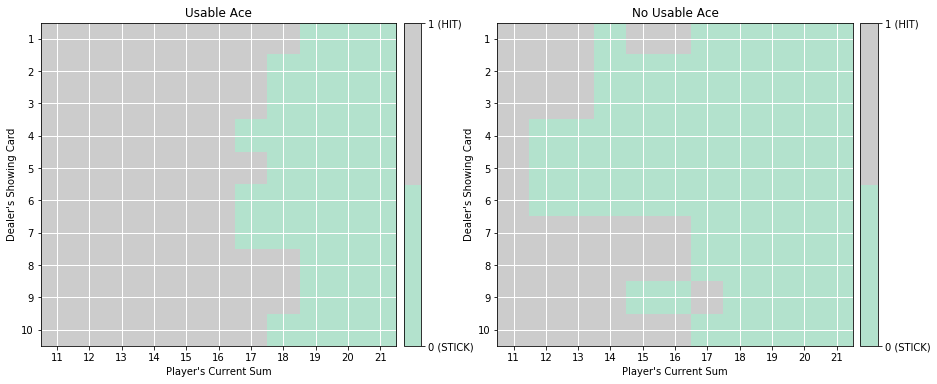

In [88]:
# plot the policy
plot_policy(policy_new)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)